# BE Noté _Machine Learning_

## Partie 1. Analyse de données ISAR

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1. On commence par observer la base de données.

A10 162
F4 162
F14 162
F16 162
F15 162


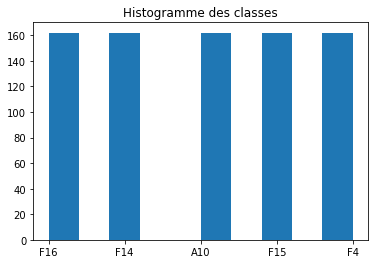

In [9]:
# On charge les noms de fichiers dans une liste
files = os.listdir('images_ISAR')

# les noms sont de la forme classe_nbr.bmp
# on extrait les classes
classes = [f.split('_')[0] for f in files]

# on extrait le nombre d'images par classe
for c in set(classes):
    print(c, classes.count(c))

# Affichage sous form d'histogramme
plt.hist(classes)
plt.title("Histogramme des classes")
plt.show()


In [10]:
# on charge une image pour analyser l'espace de données
from PIL import Image
img = Image.open('images_ISAR/'+files[0])
img = np.array(img)

print("Dimensions de l'espace de données : ", img.shape)
print("Valeur min : ", img.min())
print("Valeur max : ", img.max())

Dimensions de l'espace de données :  (256, 256)
Valeur min :  0
Valeur max :  255


Dimensions de l'espace de données :  (61, 133)
Gain en taille :  8.07789966720079


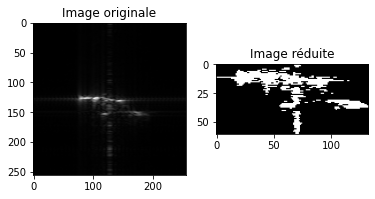

In [11]:
# On commence par réduire la taille des images en ne gardant que le centre, i.e. les valeurs les plus importantes
# on supprime les valeurs inférieures à une valeur donnée, et on garde les autres dans un ndarray de la bonne taille
def crop_image(img, threshold=40):
    res = np.copy(img)
    res[res<threshold] = 0
    res[res>=threshold] = 1
    # on supprime les lignes et colonnes nulles
    res = res[res.any(axis=1)]
    res = res[:, res.any(axis=0)]
    return res

# on applique la fonction à l'image de test
img_crop = crop_image(img)
print("Dimensions de l'espace de données : ", img_crop.shape)
print("Gain en taille : ", img.size/img_crop.size)

# on affiche les deux images
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Image originale")
plt.subplot(1,2,2)
plt.imshow(img_crop, cmap='gray')
plt.title("Image réduite")
plt.show()

In [12]:
def img_crop_size(img, xmax=32, ymax=0):
    ymax = xmax if ymax==0 else ymax
    # garde une image de taille xmax*ymax construite depuis le centre de l'image
    # permet aussi une normalisation des images en taille
    res = np.zeros((xmax, ymax), dtype=np.uint8)
    x0 = img.shape[0] // 2
    y0 = img.shape[1] // 2
    x1 = x0 - xmax // 2
    y1 = y0 - ymax // 2
    res = img[x1:x1+xmax, y1:y1+ymax]
    return res


2. On charge toutes les images dans une matrice de données.

In [13]:
# on charge toutes les images dans une matrice de données

# on crée une matrice de données vide
data = np.zeros((len(files), img.shape[0], img.shape[1]), dtype=np.uint8)

# on charge les images
for i, f in enumerate(files):
    img = Image.open('images_ISAR/'+f)
    img = np.array(img)
    data[i] = img

print("Dimensions de la matrice de données : ", data.shape)

# on charge les labels (classes)
labels = np.array(classes)
print("Dimensions du vecteur de labels : ", labels.shape)

Dimensions de la matrice de données :  (810, 256, 256)
Dimensions du vecteur de labels :  (810,)


In [14]:
# on crop toutes les images
tmp = []

for i, img in enumerate(data):
    img_crop = crop_image(img)
    tmp.append(img_crop)

xmin = min([img.shape[0] for img in tmp])
ymin = min([img.shape[1] for img in tmp])

print("Dimensions minimales : ", xmin, ymin)
print("Gain en dimension : ", data.shape[1]*data.shape[2]/(xmin*ymin))

data_crop = np.zeros((len(files), xmin, ymin), dtype=np.uint8)

for i, img in enumerate(tmp):
    img_crop = img_crop_size(img, xmin, ymin)
    data_crop[i] = img_crop

print("Dimensions de la matrice de données : ", data_crop.shape)

Dimensions minimales :  20 36
Gain en dimension :  91.02222222222223
Dimensions de la matrice de données :  (810, 20, 36)


## Partie 2. Extraction des caractéristiques discriminantes -- image polaire

1. On commence par transformer les images du plan cartésien au plan polaire.

In [15]:
import skimage.transform as skt

def polaire(img, center=None, radius=None):
    # on transforme l'image en image polaire
    # on utilise la fonction skimage.transform.warp_polar
    # on utilise les valeurs par défaut pour les paramètres center et radius
    # on retourne l'image polaire
    return skt.warp_polar(img, center=center, radius=radius)

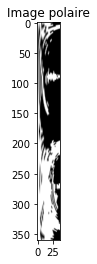

Nouvelle dimension :  (360, 37)


In [16]:
img_polaire = polaire(img, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)
plt.imshow(img_polaire, cmap='gray')
plt.title("Image polaire")
plt.show()

print("Nouvelle dimension : ", img_polaire.shape)

In [18]:
# on applique la transformation à toutes les images
data_polaire = np.zeros((len(files), img_polaire.shape[0], img_polaire.shape[1]), dtype=np.uint8)

for i, img in enumerate(data_crop):
    img_polaire = polaire(img, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)
    if img_polaire.shape[0] > data_polaire.shape[1]:
        img_polaire = img_polaire[:data_polaire.shape[1], :]
    elif img_polaire.shape[0] < data_polaire.shape[1]:
        img_polaire = np.pad(img_polaire, ((0, data_polaire.shape[1]-img_polaire.shape[0]), (0,0)), 'constant')
    data_polaire[i] = img_polaire

print("Taille de l'espace de représentation : ", data_polaire.shape)

Taille de l'espace de représentation :  (810, 360, 10)


2. On évalue maintenant l'impact de transformations géométriques sur ces images polaires.
On applique pour cela des transformations à une image au hasard, puis on affiche les résultats.

In [19]:
## Définition des transformations géométriques
def rotation(img, angle):
    # on applique une rotation de l'image d'un angle donné
    # on retourne l'image transformée
    return skt.rotate(img, angle)

def change_echelle(img_orig, scale):
    # on applique une transformation d'échelle à une image originale
    # on retourne l'image transformée et sa projection polaire
    return skt.rescale(img_orig, scale), polaire(skt.rescale(img_orig, scale), center = (img_orig.shape[0]//2, img_orig.shape[1]//2), radius = img_orig.shape[0]//2)


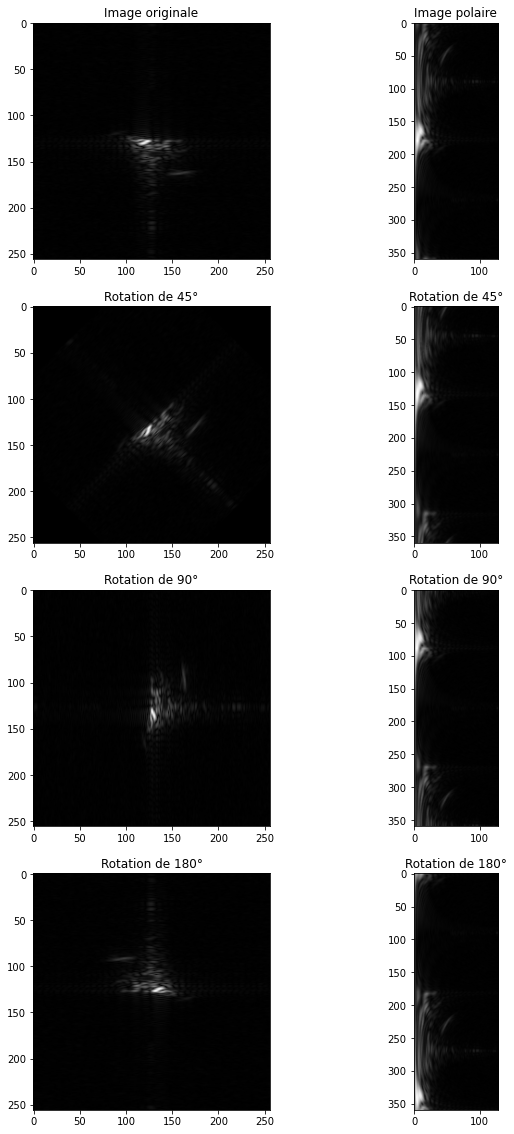

In [20]:
## On applique les transformations à une image au hasard
img = data[6]
img_polaire = polaire(img, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)

# on applique une rotation
img_rot45 = rotation(img, 45)
img_rot90 = rotation(img, 90)
img_rot180 = rotation(img, 180)
img_pol_rot45 = polaire(img_rot45, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)
img_pol_rot90 = polaire(img_rot90, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)
img_pol_rot180 = polaire(img_rot180, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)

rots = [45, 90, 180]

# on affiche les résultats et on compare les images
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
for i, img in enumerate([img, img_rot45, img_rot90, img_rot180]):
    ax[i, 0].imshow(img, cmap='gray')
    ax[i, 0].set_title("Image originale" if i == 0 else f"Rotation de {rots[i-1]}°")
for i, img in enumerate([img_polaire, img_pol_rot45, img_pol_rot90, img_pol_rot180]):
    ax[i, 1].imshow(img, cmap='gray')
    ax[i, 1].set_title("Image polaire" if i == 0 else f"Rotation de {rots[i-1]}°")
plt.show()

> On remarque que la rotation a un impact faible mais non négligeable sur les images (en-deçà de 180°). En effet, les images polaires sont déformées par la rotation, ce qui peut avoir un impact sur la classification.

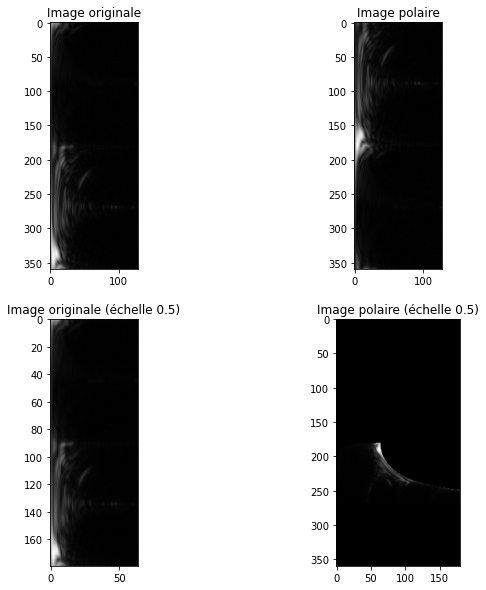

In [21]:
# on applique une transformation d'échelle
img_scale05, img_pol_scale05 = change_echelle(img, 0.5)

# on affiche les résultats et on compare les images
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].set_title("Image originale")
ax[0, 1].imshow(img_polaire, cmap='gray')
ax[0, 1].set_title("Image polaire")
ax[1, 0].imshow(img_scale05, cmap='gray')
ax[1, 0].set_title("Image originale (échelle 0.5)")
ax[1, 1].imshow(img_pol_scale05, cmap='gray')
ax[1, 1].set_title("Image polaire (échelle 0.5)")
plt.show()

> On remarque que la transformation d'échelle a un impact plus important sur les images polaires. En effet, les images polaires sont déformées par la transformation d'échelle, ce qui peut avoir un impact sur la classification.

Pour rendre les résultats invariants par translation, on peut identifier la direction moyenne de l'objet dans l'image originale, et prendre cette direction comme référence.

3. On complète la phase d'extraction, en séparant les caractéristiques par projection sur $r$ et $\theta$.

In [22]:
## Définition des fonctions de projection
def proj_r(img):
    # on projette l'image sur r
    # on retourne le vecteur de projection
    return np.sum(img, axis=1)

def proj_theta(img):
    # on projette l'image sur theta
    # on retourne le vecteur de projection
    return np.sum(img, axis=0)


In [23]:
def polaire_proj(img, center, radius):
    # on applique la transformation polaire à une image
    # on retourne l'image transformée et ses projections sur r et theta
    img_polaire = polaire(img, center, radius)
    return img_polaire, proj_r(img_polaire), proj_theta(img_polaire)

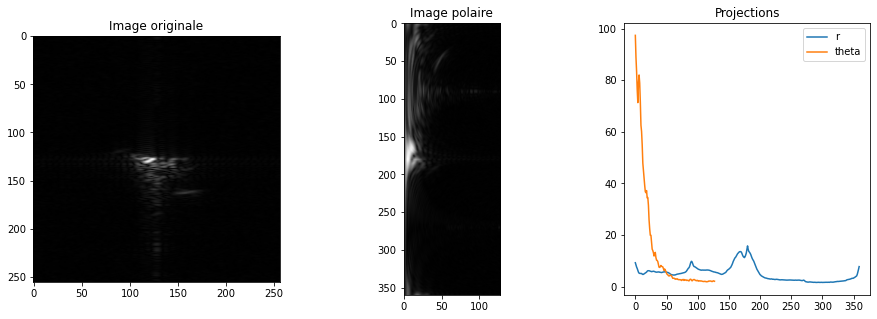

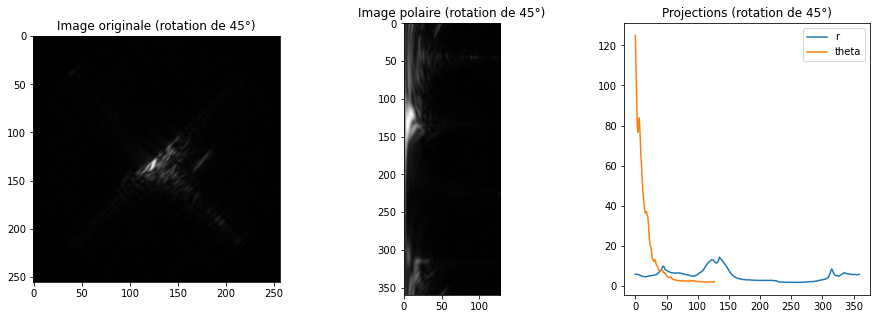

In [24]:
## On applique les transformations à une image au hasard
img = data[6]
pol, projR, projTheta = polaire_proj(img, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)

# on affiche les résultats originaux
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Image originale")
ax[1].imshow(pol, cmap='gray')
ax[1].set_title("Image polaire")
ax[2].plot(projR, label="r")
ax[2].plot(projTheta, label="theta")
ax[2].legend()
ax[2].set_title("Projections")
plt.show()

# on applique une rotation
img_rot45 = rotation(img, 45)
pol_rot45, projR_rot45, projTheta_rot45 = polaire_proj(img_rot45, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)

# on affiche les résultats de la rotation
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_rot45, cmap='gray')
ax[0].set_title("Image originale (rotation de 45°)")
ax[1].imshow(pol_rot45, cmap='gray')
ax[1].set_title("Image polaire (rotation de 45°)")
ax[2].plot(projR_rot45, label="r")
ax[2].plot(projTheta_rot45, label="theta")
ax[2].legend()
ax[2].set_title("Projections (rotation de 45°)")
plt.show()

> On remarque bien l'invariance de la projection sur $\theta$ par rotation, il s'agit donc d'une caractéristique intéressante pour la classification. À noter que la projection sur $r$ ne l'est pas.

Dans le doute, on calcule quand même la distance euclidienne pour voir la similarité entre une image et sa rotation en termes de projection.

In [25]:
# on calcule la distance euclidienne entre les projections
print("Distance en r : " + str(np.linalg.norm(projR - projR_rot45)))
print("Distance en theta : " + str(np.linalg.norm(projTheta - projTheta_rot45)))

Distance en r : 74.61999084027637
Distance en theta : 36.77697370953455


> La distance en $\theta$ reste faible, on peut donc considérer que la projection sur $\theta$ est invariante par rotation.

On continue la comparaison avec une _cross-corrélation_ pour estimer la translation observée sur la projection en $\theta$.

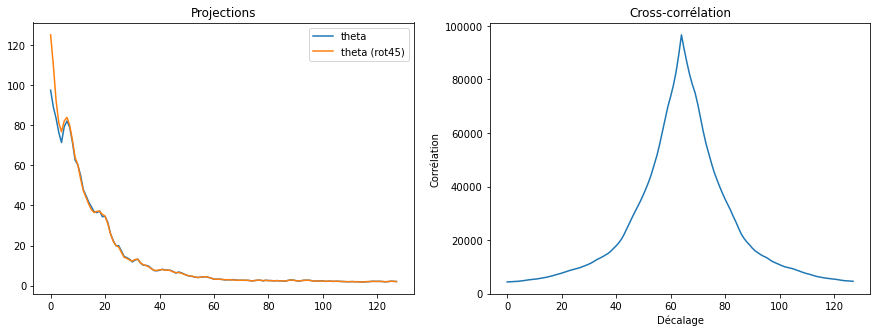

In [26]:
from scipy import signal

# on calcule la cross-corrélation entre les projections
corr = signal.correlate(projTheta, projTheta_rot45, mode='same')
# on affiche les résultats
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(projTheta, label="theta")
ax[0].plot(projTheta_rot45, label="theta (rot45)")
ax[0].legend()
ax[0].set_title("Projections")
ax[1].plot(corr)
ax[1].set_xlabel("Décalage")
ax[1].set_ylabel("Corrélation")
ax[1].set_title("Cross-corrélation")
plt.show()

In [27]:
img = data[6]

In [28]:
# on prend comme vecteur de caractéristique l'image polaire et les deux projections
def get_features(img, center, radius):
    # on retourne les caractéristiques de l'image
    img_polaire, projR, projTheta = polaire_proj(img, center, radius)
    return img_polaire, projR, projTheta


In [29]:
print("Nouvelle dimension de l'espace de caractéristiques : " + str(get_features(img, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)[0].shape))

size_before = img.shape[0] * img.shape[1]
size_after = get_features(img, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)[0].shape[0] * get_features(img, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)[0].shape[1]
print("Gain en dimension : " + str(size_after / size_before))

Nouvelle dimension de l'espace de caractéristiques : (360, 128)
Gain en dimension : 0.703125


## Partie 3. Classification : reconnaissance

1. On charge depuis un répertoire donné les images ISAR et on calcule les descripteurs pour chacune d'elles.

In [30]:
from skimage.io import imread

def descripteurs_bdd(dir):
    # on retourne les descripteurs de la base de données
    # on charge les images
    res = []
    for filename in os.listdir(dir):
        img = imread(os.path.join(dir,filename))
        if img is not None:
            res.append(img)
    # on calcule les descripteurs
    descripteurs = []
    for img in res:
        descripteurs.append(get_features(img, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2))
    return np.asarray(descripteurs)


In [35]:
# on charge les images
descripteurs = descripteurs_bdd("images_ISAR")
print("Nombre d'images chargées : " + str(len(descripteurs)))

# matrice data contenant les images, caractéristiques et labels
data = np.zeros((len(descripteurs), 4), dtype=object)
data[:,0] = descripteurs[:,0]
data[:,1] = descripteurs[:,1]
data[:,2] = descripteurs[:,2]
data[:,3] = [filename.split("_")[0] for filename in os.listdir("images_ISAR")]

Nombre d'images chargées : 810


2. On sépare la base de données en base d'apprentissage et base de test (ratio $2/3, 1/3$).

In [39]:
def reconnaissance():
    # on constitue la base d'apprentissage et de test à partir des images chargées (matrice data)
    # ratio 2/3 apprentissage, 1/3 test
    app = data[:int(len(data)*2/3)]
    test = data[int(len(data)*2/3):]
    labels_app = app[:,3]
    labels_test = test[:,3]

    return app, test, labels_app, labels_test